### Import Libraries

In [1]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader,random_split
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
from torchvision.models.feature_extraction import create_feature_extractor
from PIL import Image
import torchvision.transforms as T
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch
import seaborn as sns


### Device Configuration

In [2]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Data Augmentation and Transformation

In [3]:

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


### Load Dataset and Create Data Loaders

In [4]:
# Loading the dataset
data_dir = 'Food Classification/'
full_data = datasets.ImageFolder(data_dir, transform=train_transforms)

# Splitting the dataset into training and validation sets
dataset_size = len(full_data)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size
train_data, val_data = random_split(full_data, [train_size, val_size])

# Creating data loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_data = datasets.ImageFolder(data_dir, transform=test_transforms)
test_loader = DataLoader(test_data, batch_size=32)

print("Data loaders defined successfully:")
print(f"Training samples: {len(train_data)}, Validation samples: {len(val_data)}, Testing samples: {len(test_data)}")

Data loaders defined successfully:
Training samples: 5015, Validation samples: 1254, Testing samples: 6269


## Record count

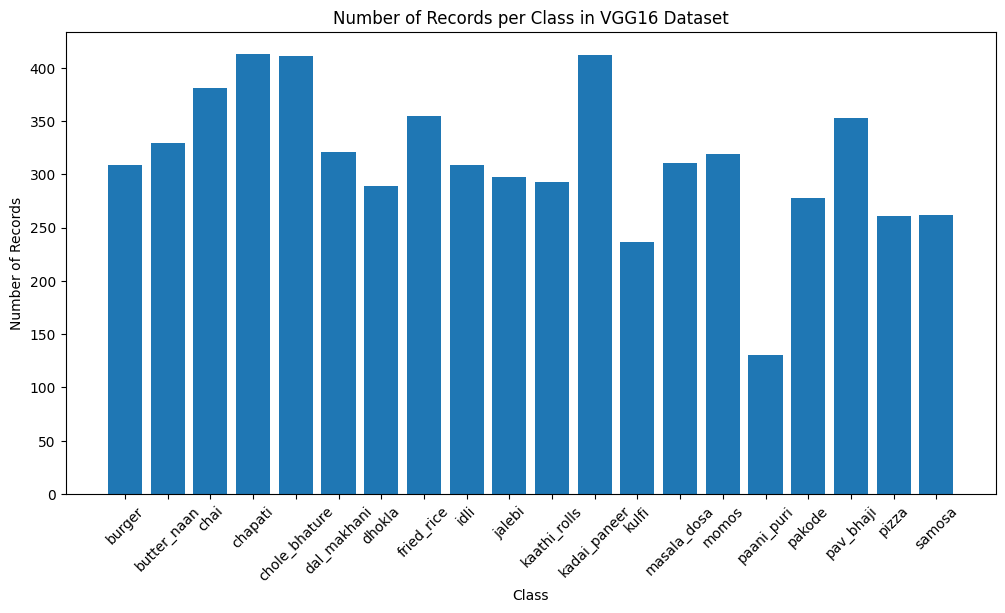

In [5]:
# Counting records for each class
class_counts = {class_name: 0 for class_name in test_loader.dataset.classes}
for _, label in test_loader.dataset.samples:
    class_name = test_loader.dataset.classes[label]
    class_counts[class_name] += 1

# Plotting record count per class
plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Number of Records')
plt.title('Number of Records per Class in VGG16 Dataset')
plt.xticks(rotation=45)
plt.show()


### Load and Modify Pre-trained VGG16 Model

In [6]:
# Loading pre-trained VGG16 model
vgg16 = models.vgg16(pretrained=True)

# Fine-tuning more layers
for name, param in vgg16.features.named_parameters():
    if '29' in name or '26' in name: 
        param.requires_grad = True
    else:
        param.requires_grad = False

# Using the original dataset to get the number of classes
num_classes = len(test_loader.dataset.classes) 

# Modifying classifier for custom number of classes
vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, num_classes)
vgg16 = vgg16.to(device)


C:\Users\shuva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\shuva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Loss Function, Optimizer

In [7]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.parameters(), lr=0.0001)

### Training Loop

In [8]:
# Lists to store loss and accuracy values for each epoch
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 10  

for epoch in range(num_epochs):

    vgg16.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = vgg16(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Statistics for training
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        total_samples += labels.size(0)
    
    # Calculate training loss and accuracy
    epoch_train_loss = running_loss / total_samples
    epoch_train_acc = running_corrects.double() / total_samples
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc.item())
    
    # Validation Phase
    vgg16.eval()
    val_loss = 0.0
    val_corrects = 0
    val_samples = 0
    
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = vgg16(val_inputs)
            val_loss_batch = criterion(val_outputs, val_labels)
            _, val_preds = torch.max(val_outputs, 1)
            
            # Statistics for validation
            val_loss += val_loss_batch.item() * val_inputs.size(0)
            val_corrects += torch.sum(val_preds == val_labels.data)
            val_samples += val_labels.size(0)
    
    # Calculating validation loss and accuracy
    epoch_val_loss = val_loss / val_samples
    epoch_val_acc = val_corrects.double() / val_samples
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc.item())
    
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc*100:.2f}%, Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc*100:.2f}%")


Epoch 1/10 - Train Loss: 1.6336, Train Acc: 50.57%, Val Loss: 1.0645, Val Acc: 68.50%
Epoch 2/10 - Train Loss: 0.9335, Train Acc: 71.43%, Val Loss: 0.9999, Val Acc: 69.54%
Epoch 3/10 - Train Loss: 0.7511, Train Acc: 77.55%, Val Loss: 0.8165, Val Acc: 75.92%
Epoch 4/10 - Train Loss: 0.6242, Train Acc: 81.06%, Val Loss: 0.8292, Val Acc: 76.08%
Epoch 5/10 - Train Loss: 0.5205, Train Acc: 83.89%, Val Loss: 0.7973, Val Acc: 76.79%
Epoch 6/10 - Train Loss: 0.4511, Train Acc: 86.04%, Val Loss: 0.7020, Val Acc: 79.74%
Epoch 7/10 - Train Loss: 0.4077, Train Acc: 87.36%, Val Loss: 0.7305, Val Acc: 78.71%
Epoch 8/10 - Train Loss: 0.3437, Train Acc: 89.27%, Val Loss: 0.8198, Val Acc: 77.83%
Epoch 9/10 - Train Loss: 0.2954, Train Acc: 90.81%, Val Loss: 0.8179, Val Acc: 78.87%
Epoch 10/10 - Train Loss: 0.2867, Train Acc: 90.87%, Val Loss: 0.8037, Val Acc: 79.59%


### Plot Training Loss

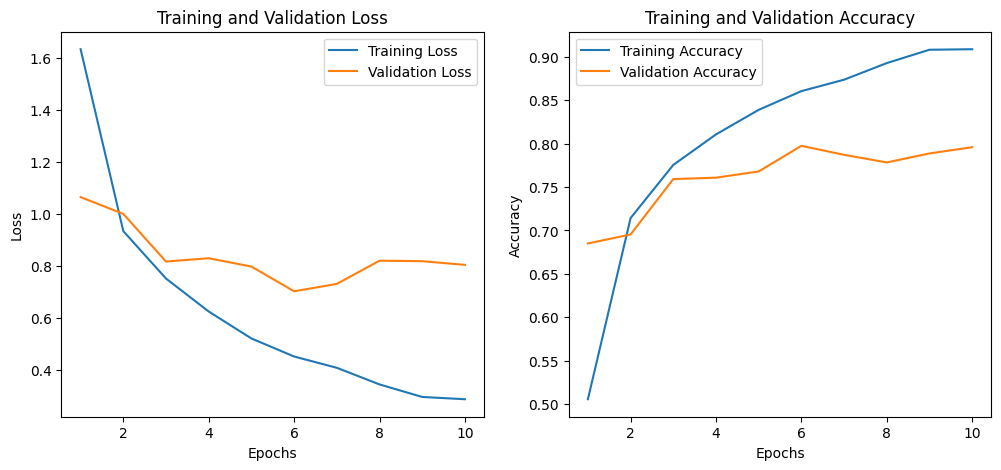

In [9]:
# Plotting Training and Validation Loss and Accuracy
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

### Evaluate Model on Test Data

In [10]:

vgg16.eval()
all_preds = []
all_labels = []
all_features = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Extracting features for t-SNE visualization
        features = vgg16.features(images).cpu().view(images.size(0), -1).numpy()
        all_features.append(features)


### Calculate and Display Metrics

In [11]:

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"F1 Score: {f1*100:.2f}%")


Test Accuracy: 94.77%
Precision: 94.88%
Recall: 94.77%
F1 Score: 94.77%


### t-SNE Visualization of Features

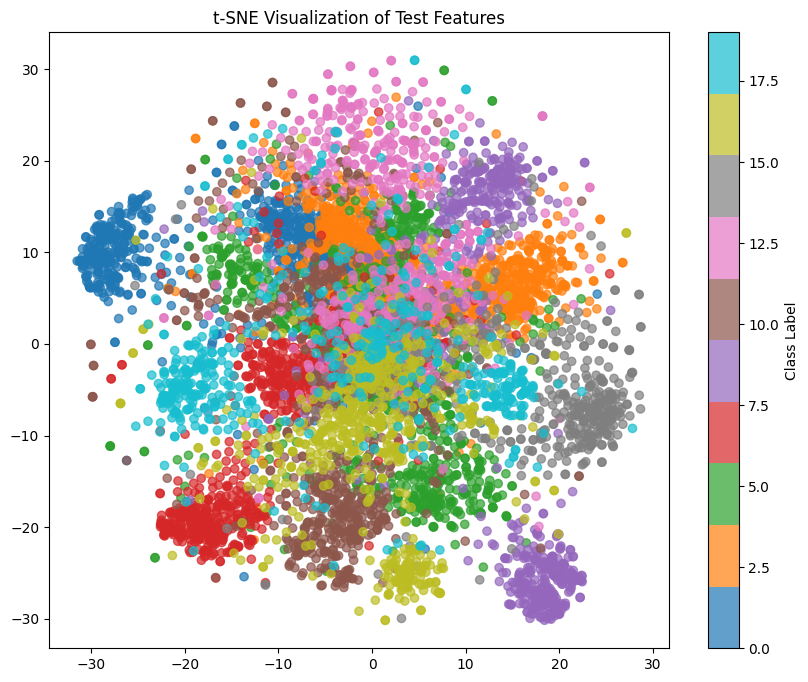

In [12]:
# Concatenating all features for t-SNE
all_features = np.concatenate(all_features, axis=0)
all_labels = np.array(all_labels)

# Applying t-SNE for feature visualization
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(all_features)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=all_labels, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, label='Class Label')
plt.title("t-SNE Visualization of Test Features")
plt.show()


### Confusion Matrix

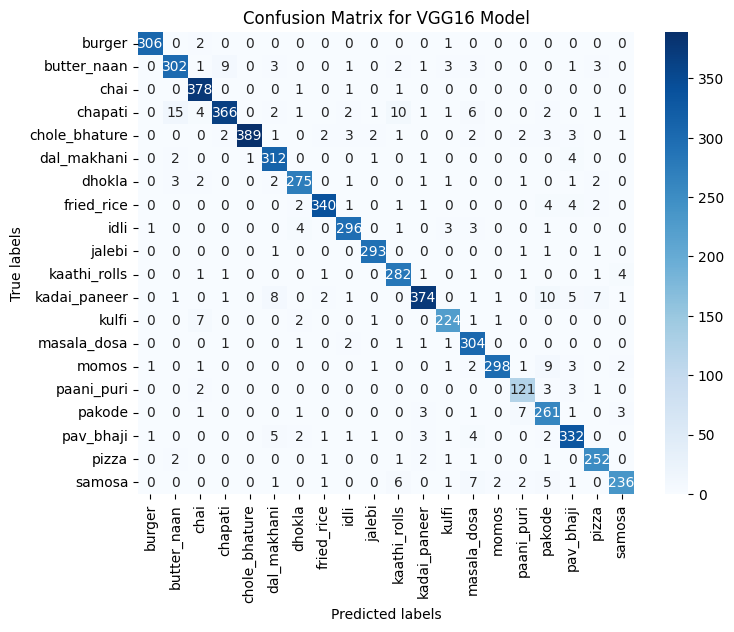

In [13]:

def test_model(model, test_loader, device):
    model.eval()  
    all_predictions = []
    all_labels = []

    with torch.no_grad():  
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)  

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Computing confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    return cm


# Calculating and displaying confusion matrix
conf_matrix = test_model(vgg16, test_loader, device)
class_names = test_loader.dataset.classes
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for VGG16 Model')
plt.show()

### Grad-CAM Function Definition

In [14]:

def apply_grad_cam(model, input_image_path, target_layer="features.28"):

    input_image = Image.open(input_image_path).convert("RGB")
    preprocess = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    input_tensor = preprocess(input_image).unsqueeze(0).to(device)

    activations = None
    gradients = []

    def save_activations_and_gradients(module, input, output):
        nonlocal activations
        activations = output 
        output.requires_grad_(True) 
        output.register_hook(lambda grad: gradients.append(grad)) 

    layer = dict([*model.named_modules()])[target_layer]
    hook_handle = layer.register_forward_hook(save_activations_and_gradients)

    model.eval()
    outputs = model(input_tensor)
    target_class = outputs.argmax(dim=1).item()
    
    model.zero_grad() 
    outputs[0, target_class].backward()

    hook_handle.remove()

    if gradients:
        pooled_grads = torch.mean(gradients[0], dim=[0, 2, 3]) 
        pooled_grads = pooled_grads.view(1, -1, 1, 1)
        activations = activations * pooled_grads.expand_as(activations)

        heatmap = torch.mean(activations, dim=1).squeeze().cpu().detach().numpy()
        heatmap = np.maximum(heatmap, 0) 
        heatmap /= heatmap.max() if heatmap.max() > 0 else 1 

        heatmap = np.uint8(heatmap * 255)
        heatmap = Image.fromarray(heatmap).resize((224, 224))
        heatmap = np.array(heatmap)

        plt.imshow(input_image)
        plt.imshow(heatmap, cmap='jet', alpha=0.5)
        plt.colorbar()
        plt.show()
    else:
        print("Gradients not captured. Ensure that backward pass is set up correctly.")

### Apply Grad-CAM to a Sample Image

Grad-CAM for Sample Image:


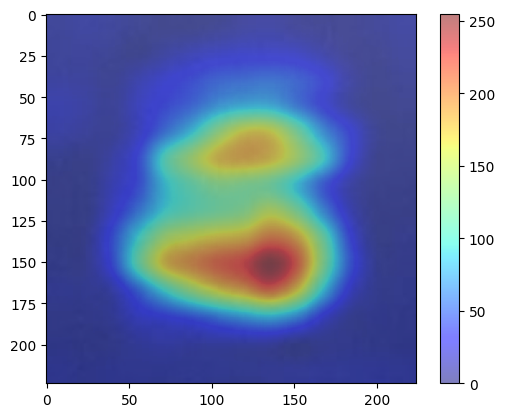

In [15]:
# Path to sample images for Grad-CAM
sample_image = 'Food Classification/burger/001.jpg'
print("Grad-CAM for Sample Image:")
apply_grad_cam(vgg16, sample_image)
